# Quantum Volume

In [2]:
from qiskit_experiments.library import QuantumVolume
from qiskit_experiments.framework import BatchExperiment
from qiskit import transpile, execute
from qiskit.circuit.library import QuantumVolume as QuantumVolumeCircuit
from qiskit.quantum_info import Statevector

from huayi_providers.fake_huayi37 import FakeHuayi37, FakeHuayi37V2
from huayi_providers.fake_QuantinuumH2 import FakeQuantinuumh2, FakeQuantinuumh2V2
from qiskit_ionq import IonQProvider
from qiskit.providers.fake_provider import *
from qiskit_aer.noise.noise_model import NoiseModel

from qiskit import Aer
from qiskit_aer import AerSimulator

import pandas as pd

## Use qiskit-experiments built-in QV measurement

**Error message**

Don't use V1 backend (including FakeHuayi12, FakeMontreal, ...)

something wrong with:

``transpiled_circuits = experiment._transpiled_circuits()``


There is also an unknown problem when n_qubits or trials is too big when use V2 backend

some discussions:

https://github.com/Qiskit-Extensions/qiskit-experiments/issues/846


In [ ]:
def collect_data(batch_data):
    results_table = pd.DataFrame()
    for i in range(batch_data.num_experiments):
        qv_result = batch_data.child_data(i).analysis_results("quantum_volume")
        data = {'QV': qv_result.value} | {'quality': qv_result.quality} | qv_result.extra
        results_table = pd.concat([results_table, pd.DataFrame(data, index=[i])], ignore_index=True)
    return results_table

In [ ]:
simulator_huayi = FakeHuayi37V2()
simulator_montreal = FakeMontrealV2()

# Each QuantumVolume() is an Experimet class
# The length of tuple() is the circuit depth
exps = [QuantumVolume(tuple(range(i)), trials=100) for i in range(3,7)]

# Batch the experiments (with different depth) into one object
batch_exp = BatchExperiment(exps)
batch_exp.set_transpile_options(optimization_level=3)

# Run with the specified backend
data_huayi = batch_exp.run(simulator_huayi).block_for_results()
data_montreal = batch_exp.run(simulator_montreal).block_for_results()

# Collect the results in the 'results_table'
results_huayi = collect_data(data_huayi)
results_montreal = collect_data(data_montreal)

# results_table = pd.DataFrame()
# for i in range(batch_exp.num_experiments):
#     qv_result = data_huayi.child_data(i).analysis_results("quantum_volume")
#     data = {'QV': qv_result.value} | {'quality': qv_result.quality} | qv_result.extra
#     results_table = pd.concat([results_table, pd.DataFrame(data, index=[i])], ignore_index=True)

display(results_huayi)
display(data_huayi.child_data(batch_exp.num_experiments-1).figure(0))

display(results_montreal)
display(data_montreal.child_data(batch_exp.num_experiments-1).figure(0))

In [ ]:
# Single run

# Each QuantumVolume() is an Experimet class
# The length of tuple() is the circuit depth
exps = QuantumVolume(tuple(range(4)), trials=160) 

# Batch the experiments (with different depth) into one object
exps.set_transpile_options(optimization_level=3)

backend = AerSimulator.from_backend(FakeMontrealV2())
# Run with the specified backend
expdata = exps.run(backend).block_for_results()

expdata.figure(0)

## From qiskit textbook

https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/measuring-quantum-volume.ipynb

Procedure:

1. Set ``ncircuits`` and ``nshots``, sweep ``depth``
2. Generate ``ncircuits`` random circuits with SU(4) gates -> ideal simulation\
   ``ideal_heavy_outputs`` list of most likely 50% output states
3. For each random SU(4) ``circuit``, transpile with the noise model.\
   ``real_counts`` simulation outputs, formatted as (output state, counts)
4. If an ``output state`` is in ``ideal_heavy_outputs``, then ``N_heavy += counts``

Finally, ${\rm HOP} = N_{\rm heavy} / N_{\rm shots} N_{\rm circs} $

Standard deviation, $\sigma = \sqrt{{\rm HOP}(1-{\rm HOP})/N_{\rm circs} }$ (as defined in the textbook, no $N_{\rm shots}$ ?)

Criteria of success: ${\rm HOP} - 2\sigma > 2/3$

In [ ]:
from quantum_volume import test_qv

In [3]:
def get_heavy_outputs(counts):
    """Extract heavy outputs from counts dict.
    Args:
        counts (dict): Output of `.get_counts()`
    Returns:
        list: All states with measurement probability greater
              than the mean.
    """
    # sort the keys of `counts` by value of counts.get(key)
    sorted_counts = sorted(counts.keys(), key=counts.get)
    # discard results with probability < median
    heavy_outputs = sorted_counts[len(sorted_counts)//2:]
    return heavy_outputs

def check_threshold(nheavies, ncircuits, nshots):
    """Evaluate adjusted threshold inequality for quantum volume.
    Args:
        nheavies (int): Total number of heavy outputs measured from device
        ncircuits (int): Number of different square circuits run on device
        nshots (int): Number of shots per circuit
    Returns:
        Bool:
            True if heavy output probability is > 2/3 with 97% certainty,
            otherwise False
    """
    from numpy import sqrt
    numerator = nheavies - 2*sqrt(nheavies*(nshots-(nheavies/ncircuits)))
    return bool(numerator/(ncircuits*nshots) > 2/3)


def test_qv(device, nqubits, ncircuits, nshots):
    """Try to achieve 2**nqubits quantum volume on device.
    Args:
        device (qiskit.providers.Backend): Device to test.
        nqubits (int): Number of qubits to use for test.
        ncircuits (int): Number of different circuits to run on the device.
        nshots (int): Number of shots per circuit.
    Returns:
        Bool
            True if device passes test, otherwise False.
    """
    from numpy import sqrt

    def get_ideal_probabilities(circuit):
        """Simulates circuit behaviour on a device with no errors."""
        state_vector = Statevector.from_instruction(
                circuit.remove_final_measurements(inplace=False)
            )
        return state_vector.probabilities_dict()

    def get_real_counts(circuit, backend, shots):
        """Runs circuit on device and returns counts dict."""
        t_circuit = transpile(circuit, backend, optimization_level=3)
        job = backend.run(t_circuit,
                          shots=shots,
                          memory=True)
        return job.result().get_counts(), t_circuit

    # generate set of random circuits
    qv_circuits = [
        QuantumVolumeCircuit(nqubits) for c in range(ncircuits)
    ]

    nheavies = [0]*ncircuits  # number of measured heavy outputs
    cum_HOP = [0]*ncircuits  # cumulant heavy-output percentage
    cum_2sigma = [0]*ncircuits  # cumulant 2-sigma deviation
    transpiled_circuits = []
    for i, circuit in enumerate(qv_circuits):
        # simulate circuit
        ideal_heavy_outputs = get_heavy_outputs(
            get_ideal_probabilities(circuit)
        )
        # run circuit on device
        circuit.measure_all()
        real_counts, t_circuit = get_real_counts(circuit, device, nshots)
        transpiled_circuits.append(t_circuit)
        # record whether device result is in the heavy outputs
        for output, count in real_counts.items():
            if output in ideal_heavy_outputs:
                nheavies[i] += count
        cum_HOP[i] = sum(nheavies[0:i+1]) / nshots / (i+1)
        cum_2sigma[i] = 2 * sqrt( cum_HOP[i] * ( 1 - cum_HOP[i] ) / (i+1) )

    # do statistical check to see if device passes test
    is_pass = check_threshold(sum(nheavies), ncircuits, nshots)
    # calculate percentage of measurements that are heavy outputs
    percent_heavy_outputs = sum(nheavies)*100/(ncircuits*nshots)

    results = {
        "backend":device.name(),
        "n_qubits":nqubits,
        "QV": 2**nqubits, 
        "HOP": percent_heavy_outputs, 
        "success": is_pass, 
        "n_circuits": ncircuits,
        "n_shots": nshots,
        "cum_HOP":cum_HOP,
        "cum_2sigma":cum_2sigma}

    print(f"Quantum Volume: {2**nqubits}\n"
          f"Percentage Heavy Outputs: {percent_heavy_outputs:.1f}%\n"
          f"Passed?: {is_pass}\n")
    return results, qv_circuits, transpiled_circuits


Quantum Volume: 256
Percentage Heavy Outputs: 76.9%
Passed?: True



(0.5, 1.0)

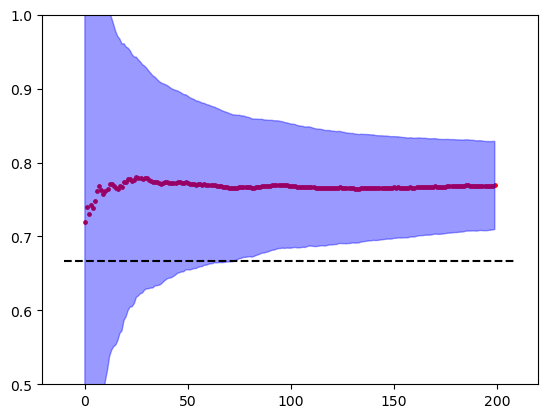

In [76]:
from huayi_providers.fake_Quantinuum_lower import FakeQuantinuum_Lower, FakeQuantinuum_LowerV2

ncircuits = 200
nshots = 100

result, qv_circs, tr_circs = test_qv(FakeQuantinuum_Lower(), 8, ncircuits=ncircuits, nshots=nshots)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.scatter(range(ncircuits), result["cum_HOP"], s=6, c='r')
ax.fill_between(range(ncircuits), 
                np.array(result["cum_HOP"]) - np.array(result["cum_2sigma"]), 
                np.array(result["cum_HOP"]) + np.array(result["cum_2sigma"]), color='b', alpha=0.4)
ax.hlines(2/3, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='k')
ax.set_ylim([0.5,1])


In [ ]:
import os
import json
import pandas as pd

if not os.path.isdir("./QV_test"):
    os.mkdir("./QV_test")

ncircuits = 500
nshots = 100

from huayi_providers.fake_Quantinuum_lower import FakeQuantinuum_Lower, FakeQuantinuum_LowerV2
from huayi_providers.fake_Quantinuum_lower_rzz import FakeQuantinuum_Lower_Rzz, FakeQuantinuum_Lower_RzzV2

results_quantinuum_low = pd.DataFrame()
results_quantinuum_low_rzz = pd.DataFrame()

for depth in range(2,16):

    result, qv_circs, tr_circs = test_qv(FakeQuantinuum_Lower(), 
                                         depth, 
                                         ncircuits=ncircuits, 
                                         nshots=nshots)
    results_quantinuum_low = pd.concat([results_quantinuum_low, 
                                        pd.DataFrame(result, 
                                                     columns=["backend", "n_qubits", "QV", "HOP", "success", "n_circuits", "n_shots"], 
                                                     index=[0])], 
                                       ignore_index=True)
    qv_export = result | {"QV_circuits": [c.qasm() for c in qv_circs]} | {"transpiled_circuits": [c.qasm() for c in tr_circs]}
    
    with open("QV_test/QV_FakeQuantinuumh2_Lower_{}.json".format(depth), 'w') as f:
        json.dump(qv_export, f)

for depth in range(2,16):

    result, qv_circs, tr_circs = test_qv(FakeQuantinuum_Lower_Rzz(), 
                                         depth, 
                                         ncircuits=ncircuits, 
                                         nshots=nshots)
    results_quantinuum_low_rzz = pd.concat([results_quantinuum_low_rzz, 
                                            pd.DataFrame(result, 
                                                         columns=["backend", "n_qubits", "QV", "HOP", "success", "n_circuits", "n_shots"], 
                                                         index=[0])], 
                                           ignore_index=True)
    qv_export = result | {"QV_circuits": [c.qasm() for c in qv_circs]} | {"transpiled_circuits": [c.qasm() for c in tr_circs]}
    
    with open("QV_test/QV_FakeQuantinuumh2_LowerRzz_{}.json".format(depth), 'w') as f:
        json.dump(qv_export, f)

Quantum Volume: 4
Percentage Heavy Outputs: 78.0%
Passed?: True

Quantum Volume: 8
Percentage Heavy Outputs: 81.3%
Passed?: True

Quantum Volume: 16
Percentage Heavy Outputs: 82.7%
Passed?: True

Quantum Volume: 32
Percentage Heavy Outputs: 83.5%
Passed?: True

Quantum Volume: 64
Percentage Heavy Outputs: 80.9%
Passed?: True

Quantum Volume: 128
Percentage Heavy Outputs: 81.0%
Passed?: True

Quantum Volume: 256
Percentage Heavy Outputs: 77.3%
Passed?: True

Quantum Volume: 512
Percentage Heavy Outputs: 76.2%
Passed?: True

Quantum Volume: 1024
Percentage Heavy Outputs: 72.3%
Passed?: True

Quantum Volume: 2048
Percentage Heavy Outputs: 71.2%
Passed?: True

Quantum Volume: 4096
Percentage Heavy Outputs: 67.8%
Passed?: False

Quantum Volume: 8192
Percentage Heavy Outputs: 66.4%
Passed?: False

Quantum Volume: 16384
Percentage Heavy Outputs: 63.4%
Passed?: False

Quantum Volume: 32768
Percentage Heavy Outputs: 62.2%
Passed?: False

Quantum Volume: 4
Percentage Heavy Outputs: 78.3%
Passed?

## Benchmark results

basis_gates = ['id', 'rx', 'ry', 'cz', 'reset']

### FakeHuayi37

- num qubits = 37
- 1q-gate error ~= 0.5%
- 2q-gate error ~= 2% (d=1) 4% (d=2,3,4)
- readout error ~= 0.05%

### FakeQuantinuumh2
 
- num qubits = 32 
- 1q-gate error ~= 0.15%
- 2q-gate error ~= 0.45% (d=1,2) 1% (d=3,4,5)
- readout error ~= 0.05%

In [78]:
display( results_huayi )
display( results_quantinuum )

,backend,n_qubits,QV,HOP,success,n_circuits,n_shots,2sigma
0,fake_huayi37,1,2,99.942,True,500,100,0.215344
1,fake_huayi37,2,4,71.804,True,500,100,4.024510
2,fake_huayi37,3,8,70.756,True,500,100,4.068600
3,fake_huayi37,4,16,63.178,False,500,100,4.314015
4,fake_huayi37,5,32,60.690,False,500,100,4.368729
5,fake_huayi37,6,64,53.586,False,500,100,4.460619
6,fake_huayi37,7,128,52.586,False,500,100,4.466151
7,fake_huayi37,8,256,49.970,False,500,100,4.472135
8,fake_huayi37,9,512,50.418,False,500,100,4.471980
9,fake_huayi37,10,1024,50.108,False,500,100,4.472126


,backend,n_qubits,QV,HOP,success,n_circuits,n_shots,2sigma
0,fake_QuantinuumH2,1,2,99.954,True,500,100,0.191789
1,fake_QuantinuumH2,2,4,76.712,True,500,100,3.780443
2,fake_QuantinuumH2,3,8,78.610,True,500,100,3.667662
3,fake_QuantinuumH2,4,16,76.282,True,500,100,3.804478
4,fake_QuantinuumH2,5,32,76.222,True,500,100,3.807789
5,fake_QuantinuumH2,6,64,68.830,False,500,100,4.142879
6,fake_QuantinuumH2,7,128,67.480,False,500,100,4.189940
7,fake_QuantinuumH2,8,256,60.346,False,500,100,4.375349
8,fake_QuantinuumH2,9,512,58.306,False,500,100,4.409998
9,fake_QuantinuumH2,10,1024,53.308,False,500,100,4.462338


In [ ]:
import numpy as np
%matplotlib inline 

fig = plt.figure()
plt.plot(results_quantinuum_low['n_qubits'], results_quantinuum_low['HOP'], 'b')
plt.fill_between(results_quantinuum_low['n_qubits'], 
                np.array(results_quantinuum_low["HOP"]) - np.array(results_quantinuum_low["2sigma"]), 
                np.array(results_quantinuum_low["HOP"]) + np.array(results_quantinuum_low["2sigma"]), color='b', alpha=0.2)
plt.plot(results_quantinuum_low_rzz['n_qubits'], results_quantinuum_low_rzz['HOP'], 'r')
plt.fill_between(results_quantinuum_low_rzz['n_qubits'], 
                np.array(results_quantinuum_low_rzz["HOP"]) - np.array(results_quantinuum_low_rzz["2sigma"]), 
                np.array(results_quantinuum_low_rzz["HOP"]) + np.array(results_quantinuum_low_rzz["2sigma"]), color='r', alpha=0.2)
plt.hlines(2/3*100, 0, 11, color='k', linestyle='dashed' )
plt.xlabel('num qubits (log_2 QV)')
plt.ylabel('HOP (%)')


In [79]:
FakeHuayi37().configuration().basis_gates

['id', 'rx', 'ry', 'cz', 'reset']

In [132]:
from qiskit import QuantumCircuit

test = ''' OPENQASM 2.0;
include "qelib1.inc";

gate r1q(theta, phi) q { U(theta, phi-π/2, π/2-phi) q; }

qreg q[2];

r1q(0,π/3) q[0];
'''

qc = QuantumCircuit.from_qasm_str(test)
qc.decompose().draw()


QASM2ParseError: '<input>:4,38: encountered a non-ASCII byte: CF'

In [94]:
from qiskit.providers.models.backendconfiguration import QasmBackendConfiguration, GateConfig

GateConfig(
    name='id',
    parameters=[],
    qasm_def="gate id q { id q; }",
    coupling_map=[[i] for i in range(5)]
    )


GateConfig(id, [], gate id q { id q; }, [[0], [1], [2], [3], [4]])

In [114]:
with open("QV_test/QV_FakeHuayi37_{}.json".format(3), 'r') as f:
    data = json.load(f)
    display(QuantumCircuit.from_qasm_str(data['QV_circuits'][0]).decompose().draw(fold=-1))
    display(QuantumCircuit.from_qasm_str(data['transpiled_circuits'][0]).draw(fold=120, idle_wires=False))


┌──────────┐                            ┌──────────────────────────┐ ░ ┌─┐      
   q_0: ┤0         ├────────────────────────────┤0                         ├─░─┤M├──────
        │  Unitary │┌──────────────────────────┐│  Unitary_140480188386768 │ ░ └╥┘┌─┐   
   q_1: ┤1         ├┤0                         ├┤1                         ├─░──╫─┤M├───
        └──────────┘│  Unitary_140480188392784 │└──────────────────────────┘ ░  ║ └╥┘┌─┐
   q_2: ────────────┤1                         ├─────────────────────────────░──╫──╫─┤M├
                    └──────────────────────────┘                             ░  ║  ║ └╥┘
meas: 3/════════════════════════════════════════════════════════════════════════╩══╩══╩═
                                                                                0  1  2

┌─────────────┐  ┌────────────┐┌─────────────┐    ┌────────────┐┌─────────┐     ┌─────────┐  ┌──────────┐»
   q_2: ┤ Rx(-2.8185) ├──┤ Ry(2.1606) ├┤ Rx(-3.0476) ├─■──┤ Rx(3.0668) ├┤ Ry(π/2) ├─■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├»
        ├─────────────┤ ┌┴────────────┤└┬────────────┤ │ ┌┴────────────┤└─────────┘ │ ┌─┴─────────┴─┐├─────────┬┘»
   q_3: ┤ Rx(-2.9884) ├─┤ Ry(0.40384) ├─┤ Rx(2.7954) ├─■─┤ Rx(0.92287) ├────────────■─┤ Rx(-1.4458) ├┤ Ry(π/2) ├─»
        ├─────────────┴┐└┬────────────┤ ├────────────┤   └─────────────┘              └─────────────┘└─────────┘ »
   q_4: ┤ Rx(-0.67038) ├─┤ Ry(2.0654) ├─┤ Rx(3.0918) ├───────────────────────────────────────────────────────────»
        └──────────────┘ └────────────┘ └────────────┘                                                           »
meas: 3/═════════════════════════════════════════════════════════════════════════════════════════════════════════»
                                                                                                                 »
«                      ┌─────────────┐┌────────────┐ ┌───────────┐                                               »
«   q_2: ────────────■─┤ Rx(-2.2703) ├┤ Ry(1.6743) ├─┤ Rx(1.109) ├───────────────────────────────────────────────»
«        ┌─────────┐ │ ├─────────────┤├────────────┤┌┴───────────┴┐   ┌────────────┐┌─────────┐     ┌─────────┐  »
«   q_3: ┤ Rx(π/2) ├─■─┤ Rx(0.78361) ├┤ Ry(1.6535) ├┤ Rx(0.73707) ├─■─┤ Rx(3.1064) ├┤ Ry(π/2) ├─■───┤ Rx(π/2) ├──»
«        └─────────┘   └─────────────┘└────────────┘└─────────────┘ │ ├────────────┤└─────────┘ │ ┌─┴─────────┴─┐»
«   q_4: ───────────────────────────────────────────────────────────■─┤ Rx(1.3813) ├────────────■─┤ Rx(-1.5287) ├»
«                                                                     └────────────┘              └─────────────┘»
«meas: 3/════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                »
«                                                                                    ┌────────────┐┌─────────┐   »
«   q_2: ─────────────────────────────────────────────────────────────────────────■──┤ Rx(2.8994) ├┤ Ry(π/2) ├─■─»
«        ┌──────────┐              ┌──────────────┐┌────────────┐┌─────────────┐  │ ┌┴────────────┤└─────────┘ │ »
«   q_3: ┤ Ry(-π/2) ├────────────■─┤ Rx(0.076569) ├┤ Ry(1.3394) ├┤ Rx(0.39441) ├──■─┤ Rx(0.94013) ├────────────■─»
«        ├─────────┬┘┌─────────┐ │ └┬────────────┬┘├────────────┤├─────────────┴┐   └─────────────┘              »
«   q_4: ┤ Ry(π/2) ├─┤ Rx(π/2) ├─■──┤ Rx(2.4118) ├─┤ Ry(1.4661) ├┤ Rx(-0.87689) ├────────────────────────────────»
«        └─────────┘ └─────────┘    └────────────┘ └────────────┘└──────────────┘                                »
«meas: 3/════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                »
«          ┌─────────┐  ┌──────────┐              ┌──────────────┐┌─────────────┐┌─────────────┐ ░ ┌─┐      
«   q_2: ──┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■─┤ Rx(-0.96742) ├┤ Ry(0.74554) ├┤ Rx(-1.5155) ├─░─┤M├──────
«        ┌─┴─────────┴─┐├─────────┬┘┌─────────┐ │ ├─────────────┬┘└┬────────────┤├─────────────┤ ░ └╥┘┌─┐   
«   q_3: ┤ Rx(-2.1865) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■─┤ Rx(-1.1001) ├──┤ Ry(1.4497) ├┤ Rx(-1.0436) ├─░──╫─┤M├───
«        └─────────────┘└─────────┘ └─────────┘   └─────────────┘  └────────────┘└─────────────┘ ░  ║ └╥┘┌─┐
«   q_4: ────────────────────────────────────────────────────────────────────────────────────────░──╫──╫─┤M├
«                                                                                                ░  ║  ║ └╥┘
«meas: 3/═══════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩═
«                              